# Fake seeing for Orion map

The plan is to test the theory that the effect of seeing is to multiply the structure function by $\tanh^2 (r / 2 s_0)$ where $s_0$ is the RMS seeing width.

What we are going to do is to artificially smooth the original velocity cube by a wider Gaussian, and then recalculate the velocity moments. 

In [1]:
from pathlib import Path
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS

Read in the data cube that I made for the Luis Ángel project:

In [2]:
datapath = Path("~/Dropbox/LuisBowshocks/kinematics").expanduser()

In [3]:
cube_hdu = fits.open(datapath / "vcube.ha-wcs-csub.fits")[0]

In [4]:
w = WCS(cube_hdu.header)

In [5]:
nv, ny, nx = cube_hdu.data.shape

In [6]:
w

WCS Keywords

Number of WCS axes: 3
CTYPE : 'RA---TAN'  'DEC--TAN'  'VELO'  
CRVAL : 83.846150111  -5.436167567  18.0  
CRPIX : 3.5  1.0  31.0  
CD1_1 CD1_2 CD1_3  : -0.000148333  0.0  0.0  
CD2_1 CD2_2 CD2_3  : 0.0  0.000148333  0.0  
CD3_1 CD3_2 CD3_3  : 0.0  0.0  4.0  
NAXIS : 356  514  61

Make an array of velocities

In [7]:
_, _, vels = w.array_index_to_world_values(np.arange(nv), [0], [0])

In [8]:
vels

array([-102.,  -98.,  -94.,  -90.,  -86.,  -82.,  -78.,  -74.,  -70.,
        -66.,  -62.,  -58.,  -54.,  -50.,  -46.,  -42.,  -38.,  -34.,
        -30.,  -26.,  -22.,  -18.,  -14.,  -10.,   -6.,   -2.,    2.,
          6.,   10.,   14.,   18.,   22.,   26.,   30.,   34.,   38.,
         42.,   46.,   50.,   54.,   58.,   62.,   66.,   70.,   74.,
         78.,   82.,   86.,   90.,   94.,   98.,  102.,  106.,  110.,
        114.,  118.,  122.,  126.,  130.,  134.,  138.])

Convert that into a cube and select the core of the line (-10 to +40)

In [9]:
vcube = vels[:, None, None] * np.ones_like(cube_hdu.data)
k1 = np.argmax(vels[vels <= -30.0])
k2 = np.argmax(vels[vels <= 60.0]) + 2
k1, k2, vels[k1:k2]

(18,
 42,
 array([-30., -26., -22., -18., -14., -10.,  -6.,  -2.,   2.,   6.,  10.,
         14.,  18.,  22.,  26.,  30.,  34.,  38.,  42.,  46.,  50.,  54.,
         58.,  62.]))

Calculate the mean velocity for each spatial pixel

In [10]:
vha = np.average(
    vcube[k1:k2, ...], 
    weights=cube_hdu.data[k1:k2, ...], 
    axis=0,
)
vha

array([[17.7122633 , 17.64215729, 17.57179531, ..., 24.96699848,
        24.90508243, 24.84403234],
       [17.42658275, 17.39645344, 17.36587932, ..., 24.79952103,
        24.78475217, 24.77019964],
       [17.37488864, 17.34430742, 17.3134612 , ..., 24.66443584,
        24.64409148, 24.62366205],
       ...,
       [20.04020951, 19.85563081, 19.6749429 , ..., 20.71224119,
        20.73070081, 20.74942577],
       [19.89852631, 19.8556888 , 19.81447949, ..., 20.44829059,
        20.42082784, 20.39278326],
       [20.13402551, 20.11376069, 20.08995791, ..., 20.35862512,
        20.29858658, 20.23720189]])

In [11]:
from matplotlib import pyplot as plt

Calculate the intensity map and have a look at velocity and intensity

In [12]:
iha = np.sum(cube_hdu.data[k1:k2, ...], axis=0)

In [13]:
m = ~np.isfinite(iha * vha) | (iha < 0.0)
iha[m] = 0.0
vha[m] = np.nanmean(vha)
iha /= iha.max()

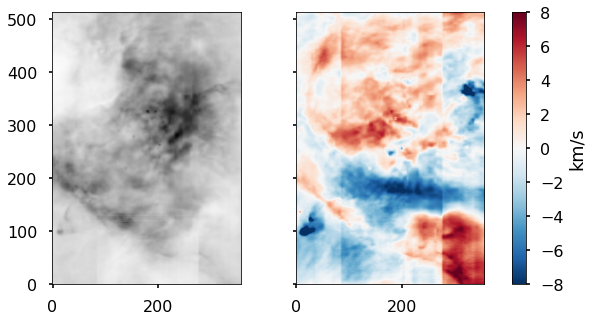

In [14]:
plt.style.use([
    "seaborn-poster",
])
fig, (ax, axx) = plt.subplots(
    1, 2, figsize=(10, 5), sharey=True,
)
im = ax.imshow(
    iha,
    origin="lower",
    vmin=0, vmax=1,
    cmap="gray_r",
)
axx.set_aspect("equal")
im = axx.imshow(
    vha - np.nanmean(vha), 
    origin="lower",
    vmin=-8, vmax=8,
    cmap="RdBu_r",
)
fig.colorbar(im, ax=[ax, axx]).set_label("km/s")
axx.set_aspect("equal")

In [15]:
np.nanmean(vha)

18.3046048389023

In [16]:
m.sum()

0

### Save the velocity and intensity images

In [17]:
outpath = Path("data/Orion-fake/")

In [18]:
fits.PrimaryHDU(
    header=w.celestial.to_header(),
    data=iha,
).writeto(outpath / "doh-ha-flux-orig.fits", overwrite=True)
fits.PrimaryHDU(
    header=w.celestial.to_header(),
    data=vha,
).writeto(outpath / "doh-ha-vmean-orig.fits", overwrite=True)

### Calculate the structure function

This is now done separately in `calculate-strucfunc.py`, which I run in a terminal.  The main reason is that the parallel multitreading in numba does not work out of the box in the jupyterlab app. 

In [19]:
import json

In [20]:
def values2arrays(d):
    for k in d.keys():
        if type(d[k]) == list:
            d[k] = np.array(d[k])
    return d

In [21]:
with open(outpath / "doh-ha-strucfunc-orig.json") as f:
    sf = values2arrays(json.load(f))

In [22]:
import astropy.units as u

In [23]:
D = 0.410 * u.kpc
pix_arcsec = 0.534
pix_pc = (pix_arcsec * (D / u.pc) * u.au).to(u.pc)
pix_pc

<Quantity 0.00106145 pc>

In [24]:
def bfunc00(r, r0, sig2, m):
    "Simple 3-parameter structure function"
    C = 1.0 / (1.0 + (r / r0)**m)
    return 2.0 * sig2 * (1.0 - C)

def seeing(r, s0):
    return (np.tanh((r / (2.0 * s0))**2))**2

def bfunc01(r, r0, sig2, m, s0):
    "Structure function with added seeing (scale `s0`)"
    return seeing(r, s0) * bfunc00(r, r0, sig2, m)

def bfunc02(r, r0, sig2, m, s0, noise):
    "Structure function with added seeing (scale `s0`) and noise"
    return seeing(r, s0) * bfunc00(r, r0, sig2, m) + noise

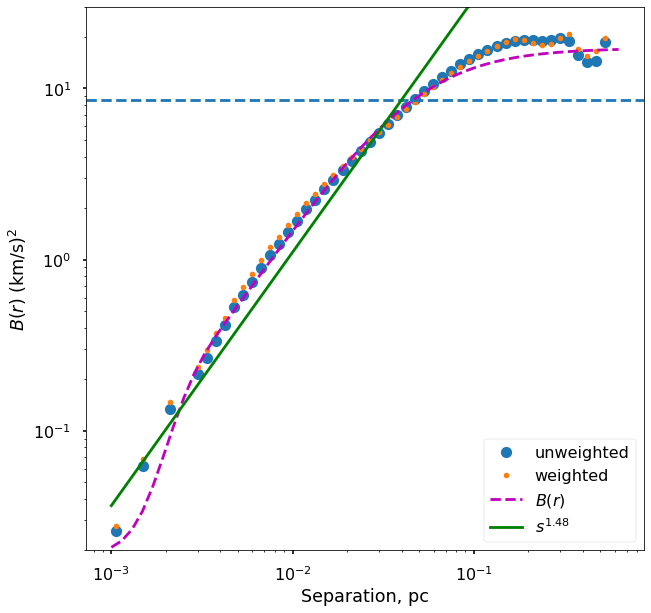

In [25]:
fig, ax = plt.subplots(figsize=(10, 10))
rgrid = np.logspace(
    np.log10(sf["sep, pc"][0]),
    np.log10(sf["sep, pc"][-1]),
    200
)
    
ax.plot(
    "sep, pc", "Unweighted B(r)", data=sf,
    linestyle="none",
    marker="o", label="unweighted",
)
ax.plot(
    "sep, pc", "Weighted B(r)", data=sf,
    linestyle="none",
    marker=".", label="weighted",
)
ax.axhline(sf["Unweighted sigma^2"], linestyle="dashed")

sig2 = sf["Unweighted sigma^2"]
r0 = sf["r0, pc"]
rgrid = np.logspace(-3.0, -0.2)
ax.plot(
    rgrid, 
    bfunc02(rgrid, r0=r0, sig2=sig2, m=1.55, s0=0.0011, noise=0.019),
    color="m", linestyle="dashed",
    label=fr"$B(r)$",
)
r0 = 0.04
mm = 1.48
ax.plot(
    rgrid, 
    sig2 * (rgrid / r0)**mm,
    color="g", linestyle="solid",
    label=fr"$s^{{{mm}}}$",
)



ax.legend()
ax.set(
    xscale="log",
    yscale="log",
    xlabel="Separation, pc",
    ylabel=r"$B(r)$ (km/s)$^2$",
    ylim=[2e-2, 30.],
);

## Smearing the velocity cube

In [26]:
from astropy.convolution import Gaussian2DKernel, convolve_fft

Do a series of widths, increasing by factors of 2. And write them all to files.

In [27]:
widths = [1, 2, 4, 8, 16, 32]

In [28]:
ihas = {}
vhas = {}
for width in widths:
    kernel = Gaussian2DKernel(x_stddev=width)
    vscube = vcube[k1:k2, ...]
    imlist = []
    for k in range(k1, k2):
        imlist.append(convolve_fft(cube_hdu.data[k, ...], kernel))
    smcube = np.stack(imlist)
    vsha = np.average(
        vscube, 
        weights=smcube, 
        axis=0,
    )
    isha = np.sum(smcube, axis=0)
    isha /= np.nanmax(isha)
    ss = f"{width:02d}"
    # Save into a dict
    vhas[width] = vsha
    ihas[width] = isha
    # And save to files
    fits.PrimaryHDU(
        header=w.celestial.to_header(),
        data=isha,
    ).writeto(
        outpath / f"doh-ha-flux-s{ss}.fits",
        overwrite=True,
    )
    fits.PrimaryHDU(
        header=w.celestial.to_header(),
        data=vsha,
    ).writeto(
        outpath / f"doh-ha-vmean-s{ss}.fits",
        overwrite=True,
    )    

Look at all the images we just made

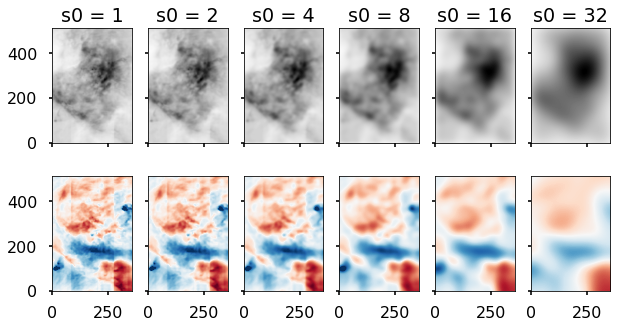

In [29]:
ncols = len(widths)
fig, axgrid = plt.subplots(
    2, ncols, figsize=(10, 5), sharex=True, sharey=True,
)
for ax, width in zip(axgrid[0], widths):
    im = ax.imshow(
        ihas[width],
        origin="lower",
        vmin=0, vmax=1,
        cmap="gray_r",
    )
    ax.set_aspect("equal")
    ax.set_title(f"s0 = {width}")
for ax, width in zip(axgrid[1], widths):
    im = ax.imshow(
        vhas[width] - np.nanmean(vha), 
        origin="lower",
        vmin=-8, vmax=8,
        cmap="RdBu_r",
    )

That looks like it worked. Now calculate the structure function for these (again with external script – we just load the json results here).

In [30]:
sfs = {}
for width in widths:
    with open(outpath / f"doh-ha-strucfunc-s{width:02d}.json") as f:
        sfs[width] = values2arrays(json.load(f))

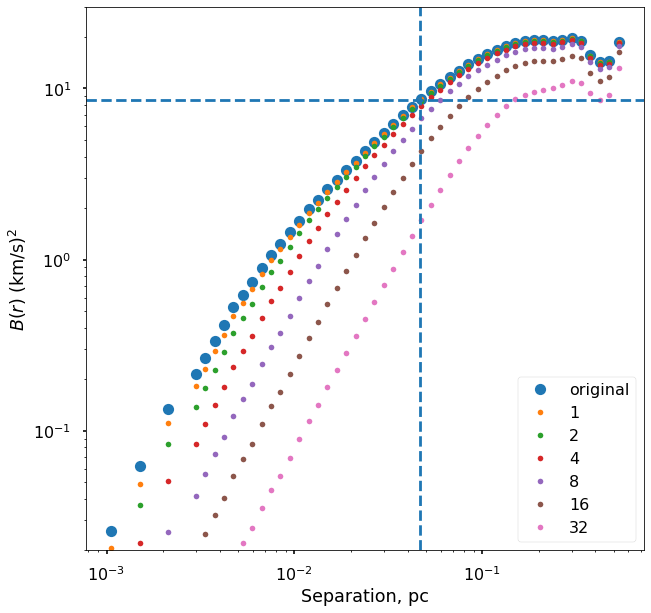

In [31]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.plot(
    "sep, pc", "Unweighted B(r)", data=sf,
    linestyle="none",
    marker="o",
    label="original",
)
for width in widths:
    ax.plot(
        "sep, pc", "Unweighted B(r)", data=sfs[width],
        linestyle="none",
        marker=".",
        label=f"{width}",
    )


ax.axhline(sf["Unweighted sigma^2"], linestyle="dashed")
ax.axvline(sf["r0, pc"], linestyle="dashed")


ax.legend()
ax.set(
    xscale="log",
    yscale="log",
    xlabel="Separation, pc",
    ylabel=r"$B(r)$ (km/s)$^2$",
    ylim=[2e-2, 30.],
);

That did not work out according to the naive theory.  The deviations from the unsmoothed structure function are more gradual than expected. 

In [32]:
mm = sf["N pairs"] > 0
ratio = sfs[8]["Unweighted B(r)"] / sf["Unweighted B(r)"]
ratio[mm]

array([0.15394138, 0.18095407, 0.19121137, 0.19528845, 0.2115213 ,
       0.2162283 , 0.22331117, 0.23303951, 0.24746564, 0.25572106,
       0.27188548, 0.28800729, 0.30458273, 0.32632052, 0.35348593,
       0.38186284, 0.41168239, 0.44609976, 0.48289517, 0.51887195,
       0.55687752, 0.59306021, 0.62736572, 0.65930166, 0.68972884,
       0.71710093, 0.74218889, 0.76611597, 0.78842414, 0.80814174,
       0.82449125, 0.83821495, 0.84914171, 0.85822358, 0.86707606,
       0.87416705, 0.8810576 , 0.8879645 , 0.89065495, 0.89307865,
       0.89501831, 0.89838277, 0.90486197, 0.91502435, 0.91849933,
       0.90988942, 0.90087431, 0.9224464 , 0.9534523 ])

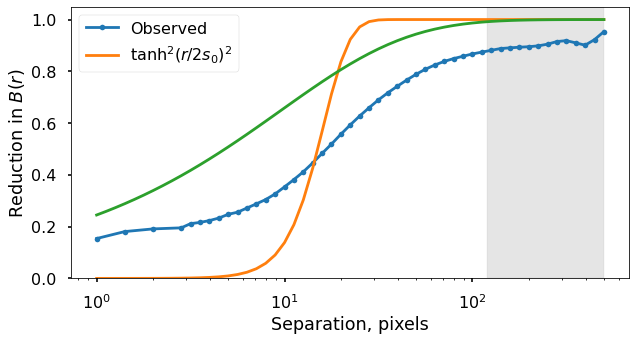

In [33]:
fig, ax = plt.subplots(figsize=(10, 5))
r = 10**sf["log10 r"]
width = 8
ax.plot(r[mm], ratio[mm], marker=".", label="Observed")
ax.plot(r, seeing(r, width), label=r"$\tanh^2 (r/2s_0)^2$")
ax.plot(r,
        np.tanh((r / (2 * width))**0.5)
       )
ax.axvspan(120, 500, color="k", alpha=0.1)
ax.legend()
ax.set(
    xscale="log",
    ylim=[0, None],
    xlabel="Separation, pixels",
    ylabel="Reduction in $B(r)$"
);

### Compare the different smoothing scales

The reason that the ratio does not go to zero at small separations is that the observations are already smoothed by the *real* seeing.  So our fake seeing needs to be applied on top of that.

In [47]:
def ratio_empirical(rad, s0, a=1.0):
    """
    Simple tanh law in semi-log space to fit the seeing
    
    Reduction in B(r) is always 0.5 when r = 2 * s0
    Parameter `a` controls the slope of the transition.
    """
    x = np.log(rad / (2 * s0))
    y = np.tanh(a * x)
    return 0.5 * (1.0 + y)

def rtheo(rad, s0, s00=2, **kwds):
    """
    Theoretical ratio of B(r) structure function
    
    For an additional seeing FWHM of s0, assuming that 
    the original seeing was s00 (widths assumed to add in quadrature)
    """
    s1 = np.hypot(s0, s00)
    return (
        ratio_empirical(rad, s1, **kwds) 
        / ratio_empirical(rad, s00, **kwds)
    )

def bfac(x):
    """
    Across-the board reduction in B(r) for x = s0 / r0
    
    Where s0 is RMS seeing width and r0 is correlation length
    """
    #return 1 / (1 + 4*x**2)
    return np.exp(-x)

1 44.17016431123298 0.831512958982732
2 44.77390968939819 0.6973142101113678
4 46.4875274176551 0.558703937340869
8 50.418906364358826 0.48570557780932205
16 59.451852348413276 0.4012653977445307
32 77.77965812349532 0.2700009356985449


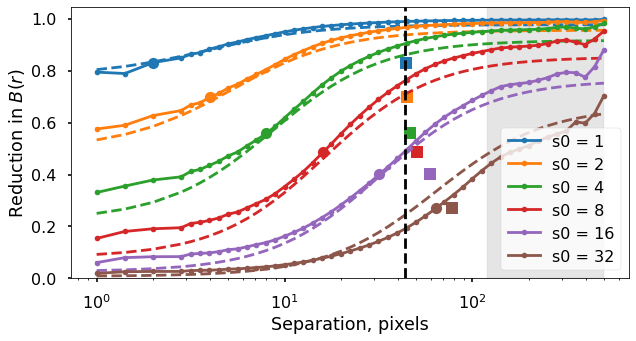

In [50]:
fig, ax = plt.subplots(figsize=(10, 5))
for width in widths:
    rat = sfs[width]["Unweighted B(r)"] / sf["Unweighted B(r)"]
    plotline = ax.plot(r[mm], rat[mm], marker=".", label=f"s0 = {width}")
    c = plotline[0].get_color()
    r0 = sfs[width]["r0, pc"] / pix_pc.value
    ax.plot(
        r[mm], 
        bfac(width / r0) * rtheo(r[mm], width, 1.7, a=0.75), 
        linestyle="dashed", color=c
    )
    rat0 = np.interp(2*width, r[mm], rat[mm])
    ax.plot(2*width, rat0, marker="o", color=c)
    print(width, r0, rat0)
    ax.plot(r0, rat0, marker="s", color=c)
r00 = sf["r0, pc"] / pix_pc.value
ax.axvline(r00, color="k", linestyle="dashed")
ax.axvspan(120, 500, color="k", alpha=0.1)
ax.legend()
ax.set(
    xscale="log",
    ylim=[0, None],
    xlabel="Separation, pixels",
    ylabel="Reduction in $B(r)$"
);

So that is a pretty good fit! The ratios here are the differential effect of adding more seeing (over and above what is there naturally). The best fit is with a natural seeing of `s00 = 1.5` pixels, which means a FWHM in arcsec of `0.534 * 1.5 * 2.3 = 1.84`, which seems reasonable.  
The deviations at small separations may be due to noise, which we are not accounting for properly. (The noise is applied *after* the real seeing, but *before* the fake seeing).  

Now we will look at the full effect of the fake seeing:

1 44.17016431123298 0.831512958982732
2 44.77390968939819 0.6973142101113678
4 46.4875274176551 0.558703937340869
8 50.418906364358826 0.48570557780932205
16 59.451852348413276 0.4012653977445307
32 77.77965812349532 0.2700009356985449


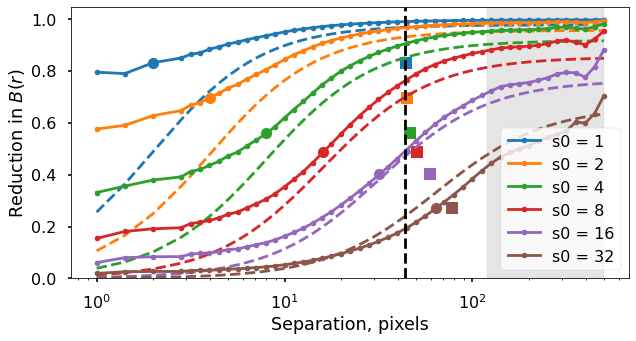

In [51]:
fig, ax = plt.subplots(figsize=(10, 5))
for width in widths:
    rat = sfs[width]["Unweighted B(r)"] / sf["Unweighted B(r)"]
    plotline = ax.plot(r[mm], rat[mm], marker=".", label=f"s0 = {width}")
    c = plotline[0].get_color()
    r0 = sfs[width]["r0, pc"] / pix_pc.value
    ax.plot(
        r[mm], 
        bfac(width / r0) * ratio_empirical(r[mm], width, a=0.75), 
        linestyle="dashed", color=c
    )
    rat0 = np.interp(2*width, r[mm], rat[mm])
    ax.plot(2*width, rat0, marker="o", color=c)
    print(width, r0, rat0)
    ax.plot(r0, rat0, marker="s", color=c)
r00 = sf["r0, pc"] / pix_pc.value
ax.axvline(r00, color="k", linestyle="dashed")
ax.axvspan(120, 500, color="k", alpha=0.1)
ax.legend()
ax.set(
    xscale="log",
    ylim=[0, None],
    xlabel="Separation, pixels",
    ylabel="Reduction in $B(r)$"
);

So, the true situation is in between the blue and orange lines. There is a significant effect up to 3 pixel separation, but the value of `r0` is almost unaffected. 

In [37]:
def seeing_empirical(r, s0, r0):
    return bfac(s0 / r0) * ratio_empirical(r, s0, a=0.75)

def bfunc03(r, r0, sig2, m, s0, noise):
    "Structure function with better seeing (scale `s0`) and noise"
    return seeing_empirical(r, s0, r0) * bfunc00(r, r0, sig2, m) + noise

## Try a different autocorrelation function

We want the turn-over to be sharper near the autocorrelation length.  But we still need that $C(r_0) = 0.5$, so $e^{-a} = 0.5$ means $a = \ln 2$. 

In [38]:
def bfunc00s(r, r0, sig2, m):
    "Simple 3-parameter structure function"
    C = np.exp(-np.log(2) * (r / r0)**m)
    return 2.0 * sig2 * (1.0 - C)

def bfunc03s(r, r0, sig2, m, s0, noise):
    "Structure function with better seeing (scale `s0`) and noise"
    return seeing_empirical(r, s0, r0) * bfunc00s(r, r0, sig2, m) + noise

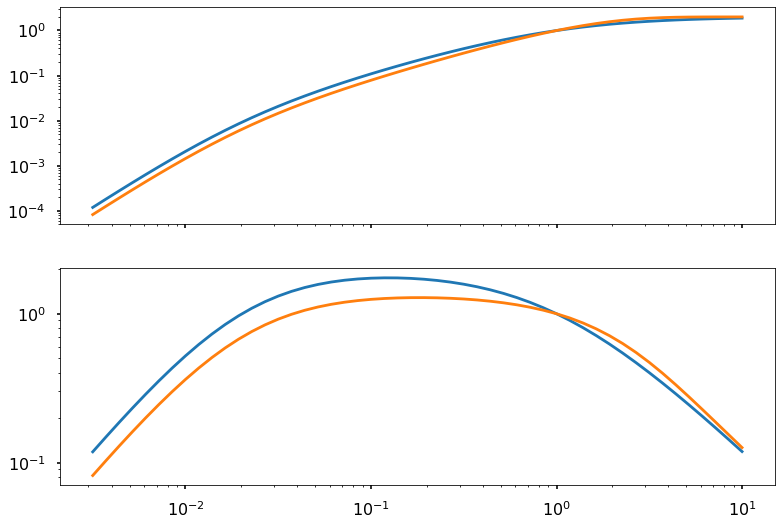

In [39]:
m = 1.2
rgrid = np.logspace(-2.5, 1.0)
fig, (ax, axx) = plt.subplots(2, 1, sharex=True)
ax.plot(rgrid, bfunc03(rgrid, 1.0, 1.0, m, 0.01, 0.0))
ax.plot(rgrid, bfunc03s(rgrid, 1.0, 1.0, m, 0.01, 0.0))
axx.plot(rgrid, bfunc03(rgrid, 1.0, 1.0, m, 0.01, 0.0) / rgrid**m)
axx.plot(rgrid, bfunc03s(rgrid, 1.0, 1.0, m, 0.01, 0.0) / rgrid**m)
for a in ax, axx:
    a.set(
        xscale="log",
        yscale="log",
    )

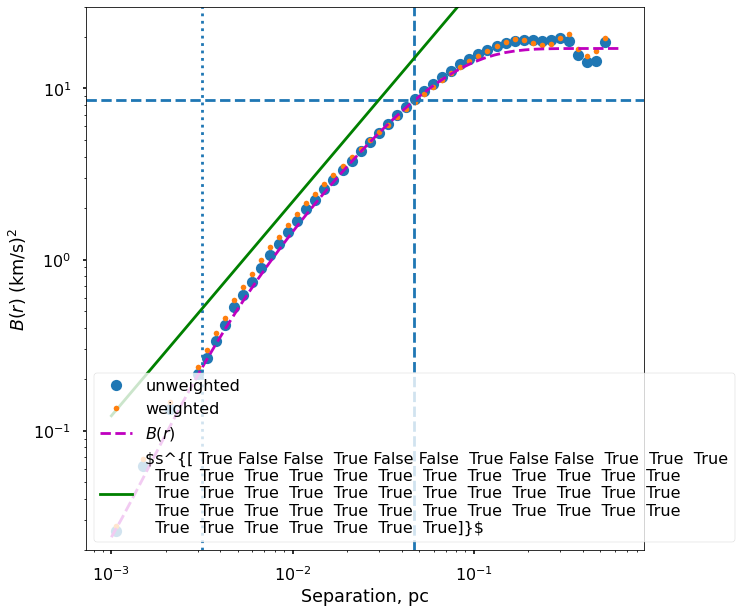

In [40]:
fig, ax = plt.subplots(figsize=(10, 10))
rgrid = np.logspace(
    np.log10(sf["sep, pc"][0]),
    np.log10(sf["sep, pc"][-1]),
    200
)
    
ax.plot(
    "sep, pc", "Unweighted B(r)", data=sf,
    linestyle="none",
    marker="o", label="unweighted",
)
ax.plot(
    "sep, pc", "Weighted B(r)", data=sf,
    linestyle="none",
    marker=".", label="weighted",
)
ax.axhline(sf["Unweighted sigma^2"], linestyle="dashed")

sig2 = sf["Unweighted sigma^2"]
r0 = sf["r0, pc"]
rgrid = np.logspace(-3.0, -0.2)
s0 = 1.5e-3 * 0.9
m = 1.25
ax.plot(
    rgrid, 
    bfunc03s(rgrid, r0=r0, sig2=sig2, m=m, s0=s0, noise=0.006),
    color="m", linestyle="dashed",
    label=fr"$B(r)$",
)

ax.axvline(r0, linestyle="dashed")
ax.axvline(2.35 * s0, linestyle="dotted")

r1 = 0.03
ax.plot(
    rgrid, 
    sig2 * (rgrid / r1)**m,
    color="g", linestyle="solid",
    label=fr"$s^{{{mm}}}$",
)



ax.legend()
ax.set(
    xscale="log",
    yscale="log",
    xlabel="Separation, pc",
    ylabel=r"$B(r)$ (km/s)$^2$",
    ylim=[2e-2, 30.],
);

The vertical dotted line is the FWHM of the seeing, which is best fir by about 1.5 arcsec, which is a bit smaller than I thought before.
The dashed vertical line is the correlation length.

In [41]:
m = 1.25
sf[f"Compensated B(r) / r^{m}"] = (
    (sf["Unweighted B(r)"] / sf["Unweighted sigma^2"])
    * (sf["r0, pc"] / sf["sep, pc"])**m
)

/tmp/ipykernel_43463/765212078.py:8: RuntimeWarning: divide by zero encountered in true_divide
  x = np.log(rad / (2 * s0))


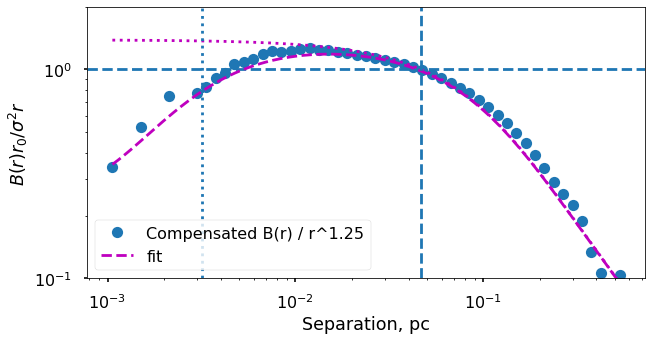

In [42]:
m = 1.25
fig, ax = plt.subplots(figsize=(10, 5))
rgrid = np.logspace(
    np.log10(sf["sep, pc"][0]),
    np.log10(sf["sep, pc"][-1]),
    200
)
    
ax.plot(
    "sep, pc", f"Compensated B(r) / r^{m}", data=sf,
    linestyle="none",
    marker="o",
)
ax.axhline(1.0, linestyle="dashed")


ax.plot(
    rgrid, 
    bfunc03s(
        rgrid, r0=r0, sig2=1.0, m=m, s0=s0, noise=0.006 / sig2
    ) * (r0 / rgrid)**m,
    color="m", linestyle="dashed",
    label="fit",
)
ax.plot(
    rgrid, 
    bfunc03s(
        rgrid, r0=r0, sig2=1.0, m=m, s0=0.0, noise=0.0
    ) * (r0 / rgrid)**m,
    color="m", linestyle="dotted",
    label="_nolabel_",
)

sig2 = sf["Unweighted sigma^2"]
r0 = sf["r0, pc"]
rgrid = np.logspace(-3.0, -0.2)

ax.axvline(r0, linestyle="dashed")
ax.axvline(2.35 * s0, linestyle="dotted")

ax.legend()
ax.set(
    xscale="log",
    yscale="log",
    xlabel="Separation, pc",
    ylabel=r"$B(r) r_0 / \sigma^2 r$",
    ylim=[0.1, 2.],
);

### Non parametric estimation of the slope

Look at the logarithmic derivatives and fit a polynomial to find the flattest part.

In [43]:
mm = sf["N pairs"] > 0
logr = sf["log10 r"][mm]
logB = np.log10(sf["Unweighted B(r)"][mm])

dlogB_dlogr = np.gradient(logB, logr)
d2logB_dlogr2 = np.gradient(dlogB_dlogr, logr)

In [44]:
from numpy.polynomial import Chebyshev as T
sli = slice(3, -10)
p = T.fit(logr[sli], logB[sli], 4)

In [45]:
xx, = p.deriv(3).roots()
pslope = p.deriv(1)(xx)
xx, pslope

(1.3567856014450197, 1.078335563659668)

[(-2.0, 2.0)]

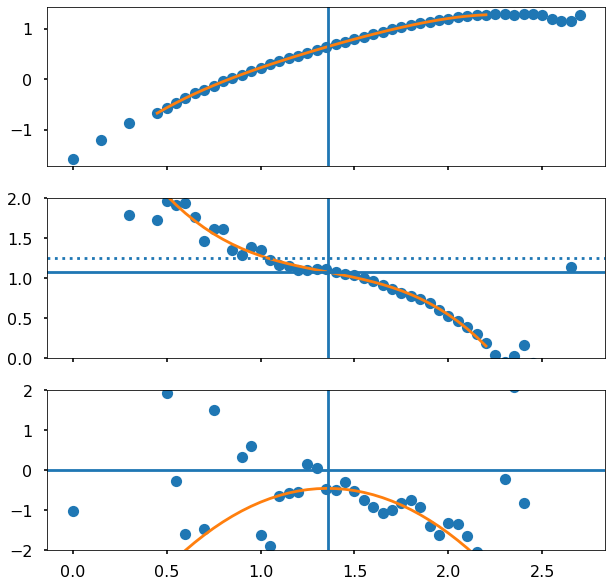

In [46]:
fig, (ax, axx, axxx) = plt.subplots(3, 1, sharex=True, figsize=(10, 10))
ax.plot(logr, logB, "o")
ax.plot(logr[sli], p(logr)[sli])
ax.axvline(xx)
axx.plot(logr, dlogB_dlogr, "o")
axx.plot(logr[sli], p.deriv(1)(logr)[sli])
axx.axhline(pslope)
axx.axhline(m, linestyle="dotted")
axx.axvline(xx)
axx.set(
    ylim = [0, 2],
)

axxx.plot(logr, d2logB_dlogr2, "o")
axxx.plot(logr[sli], p.deriv(2)(logr)[sli])
axxx.axhline(0.0)
axxx.axvline(xx)
axxx.set(
    ylim = [-2, 2],
)